## EDA

In [3]:
# Import Libraries
#초기 설정및 시스템 라이브러리
import platform
import warnings

# 데이터 시각화 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
print(platform.system())
warnings.filterwarnings('ignore')

# 행,열,결과값 생략 없이 보기,세팅
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

# 시각화 OS별 한글폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 폰트 설정
elif platform.system() == 'Mac':
    plt.rcParams['font.family'] = 'AppleGothic'  # Mac 폰트 설정
    
print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

Windows
라이브러리 로드 완료!
한글 폰트 설정 완료!


### 성장률

In [4]:
df_mna_industry    = pd.read_csv("./data/join/mna_industry_final.csv")       # M&A(산업)
df_mna_size        = pd.read_csv("./data/join/mna_size_final.csv")           # M&A(규모)
df_mna_addr        = pd.read_csv("./data/join/mna_addr_final.csv")           # M&A(위치)
df_mna_issues      = pd.read_csv("./data/join/mna_issues_final.csv")         # M&A(이슈/마일스톤)

#### 성장률(산업)
(obj, acq)
어떤 산업군에 속한 스타트업의 M&A 성공률이 높을까

In [5]:
# 분석 단위 (회사당 여러 라운드)
# df_mna_industry
print(df_mna_industry.shape) # (462770, 57)
print(df_mna_industry[["objects_cfpr_id"]].nunique()) # ignore NaN values 462620
display(round((df_mna_industry["acquired_c_id"].notna().mean()) * 100, 2)) # 2.06%

(462770, 57)
objects_cfpr_id    462620
dtype: int64


np.float64(2.06)

In [6]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
cond1 = (df_mna_industry['objects_cfpr_id'].str[0] == "c")
print(df_mna_industry.shape[0]) # 조건 부여 전 462770
mna_industry = df_mna_industry.loc[cond1]
print(mna_industry.shape[0]) # 조건 부여 후 196699

462770
196699


M&A 못한 회사가 얼마나 될까?

In [7]:
# 인수합병 못한 회사? → 196549건
cond1 = (mna_industry["acquired_c_id"].isna())
num_no_mna = mna_industry.loc[cond1, "objects_cfpr_id"].nunique()

# 전체에서 비율 → 95.22 %
mna_total_company = mna_industry["objects_cfpr_id"].nunique()
no_mna_ratio = round(num_no_mna/mna_total_company * 100, 2)

print("전체 회사 수:", mna_total_company)
print("M&A 못한 회사 수:", num_no_mna)
print("비율:", no_mna_ratio,"%")

전체 회사 수: 196549
M&A 못한 회사 수: 187155
비율: 95.22 %


TOP5 산업군은 무엇일까?

In [8]:
# 산업군 분포확인
display(mna_industry["category_code"].describe())
display(mna_industry["category_code"].value_counts(dropna=False).head(20))

count       123313
unique          42
top       software
freq         17933
Name: category_code, dtype: object

category_code
NaN                 73386
software            17933
web                 15152
other               13624
ecommerce            9076
games_video          7531
mobile               6869
advertising          6106
consulting           5008
enterprise           4449
biotech              4432
hardware             2953
education            2901
public_relations     2854
network_hosting      2355
search               2184
cleantech            1941
health               1698
finance              1386
social               1310
Name: count, dtype: int64

In [9]:
mna_industry["is_acquired"].value_counts(dropna=False)

is_acquired
0    187155
1      9544
Name: count, dtype: int64

In [10]:
# 산업군 분포확인
cond1 = (mna_industry["is_acquired"] == 1)
mna_industry.loc[cond1, "category_code"].value_counts()

category_code
software            1477
web                 1005
biotech              457
mobile               423
enterprise           417
games_video          353
other                320
advertising          320
ecommerce            282
public_relations     223
network_hosting      206
hardware             202
semiconductor        154
consulting           138
security             132
cleantech            116
search                72
analytics             40
finance               40
education             33
manufacturing         30
news                  28
health                27
social                27
messaging             25
travel                20
medical               16
music                 15
hospitality           13
photo_video           12
fashion               11
real_estate            8
transportation         7
automotive             5
sports                 5
design                 4
legal                  4
local                  3
nanotech               1
nonprofit  

산업군의 이상치는?

In [11]:
# category_code 이상치 분석
# 1) category_code가 없는 건 일단 제외 & 인수된 건만
cond1 = mna_industry["category_code"].notna()
cond2 = mna_industry["is_acquired"] == 1
mna_industry_acq = mna_industry[cond1 & cond2].copy()

# 2) (category_code, 회사) 쌍 기준으로 중복 제거 한 회사가 같은 category_code로 여러 행 있어도 1번만 카운트
mna_industry_acq_unique = mna_industry_acq.drop_duplicates(subset=["category_code", "acquired_c_id"])

# 3) category_code별 회사 수 (고유 회사 기준)
mna_cat_company_counts = (
    mna_industry_acq_unique
    .groupby("category_code")["acquired_c_id"]
    .nunique()
    .sort_values(ascending=False)
)

print("category_code별 회사 수(전체):", mna_cat_company_counts.sum())
display(mna_cat_company_counts)


category_code별 회사 수(전체): 6545


category_code
software            1466
web                  971
biotech              455
mobile               416
enterprise           409
games_video          342
other                313
advertising          312
ecommerce            271
public_relations     215
network_hosting      201
hardware             200
semiconductor        154
consulting           136
security             127
cleantech            115
search                70
finance               40
analytics             39
education             33
manufacturing         30
news                  27
social                27
health                27
messaging             24
travel                20
medical               16
music                 15
hospitality           13
photo_video           12
fashion               11
real_estate            8
transportation         7
automotive             5
sports                 5
design                 4
legal                  4
local                  3
nanotech               1
nonprofit  

In [12]:
# IQR로 이상치 파악
Q1 = mna_cat_company_counts.quantile(0.25)  # 1사분위수
Q3 = mna_cat_company_counts.quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)

Q1: 11.75
Q3: 204.5
IQR: 192.75
lower_bound: -277.375
upper_bound: 493.625


In [13]:
# 1) 상한 초과 → 회사 수가 유난히 많은 카테고리
high_outliers = mna_cat_company_counts[mna_cat_company_counts > upper_bound]

# 2) 하한 미만 → 회사 수가 유난히 적은 카테고리
low_outliers = mna_cat_company_counts[mna_cat_company_counts < lower_bound]

print("❓ 회사 수가 많은 이상치 카테고리")
print(high_outliers)

print("\n❓ 회사 수가 적은 이상치 카테고리")
print(low_outliers)

❓ 회사 수가 많은 이상치 카테고리
category_code
software    1466
web          971
Name: acquired_c_id, dtype: int64

❓ 회사 수가 적은 이상치 카테고리
Series([], Name: acquired_c_id, dtype: int64)


산업군별 M&A 성공률은?

In [14]:
# 산업군별 M&A 성공률
mna_industry_success = (
    mna_industry
    .groupby("category_code")
    .agg(
        mna_rate=("is_acquired", "mean"),            # M&A 성공률
        n_companies=("objects_cfpr_id", "nunique"),  # 산업군 내 회사 수
        n_acquired=("is_acquired", "sum")          # 인수된 회사 수
    )
    .assign(mna_rate=lambda x: round(x["mna_rate"] * 100, 2))  # %
    .sort_values("mna_rate", ascending=False)
)

display(mna_industry_success)

,mna_rate,n_companies,n_acquired
category_code,,,
semiconductor,22.13,696,154
security,11.22,1171,132
biotech,10.31,4430,457
enterprise,9.37,4441,417
network_hosting,8.75,2350,206
messaging,8.42,296,25
software,8.24,17922,1477
public_relations,7.81,2846,223
hardware,6.84,2951,202


카테고리 코드에 필터를 적용해야하지 않을까?

In [15]:
# category_code별 건수 집계
mna_cat_counts = mna_industry["category_code"].value_counts()

# IQR 계산
Q1 = mna_cat_counts.quantile(0.25)
Q3 = mna_cat_counts.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("하한(lower_bound):", lower_bound)

# Q1 이상 범위의 category_code만 선택
mna_valid_categories = mna_cat_counts[
    (mna_cat_counts >= Q1)
].index

# 데이터프레임에 정상 category_code만 남기기
mna_acq_filtered = mna_industry[mna_industry["category_code"].isin(mna_valid_categories)].copy()

print("전체 category_code 수:", mna_industry["category_code"].nunique())
print("필터 후 category_code 수:", mna_acq_filtered["category_code"].nunique())

Q1: 567.5
Q3: 2940.0
IQR: 2372.5
하한(lower_bound): -2991.25


전체 category_code 수: 42
필터 후 category_code 수: 31


In [16]:
# 산업군별 M&A 성공률 (필터적용 후)
mna_industry_success_filtered = (
    mna_acq_filtered
    .groupby("category_code")
    .agg(
        mna_rate=("is_acquired", "mean"),            # M&A 성공률
        n_companies=("objects_cfpr_id", "nunique"),  # 산업군 내 회사 수
        n_acquired=("is_acquired", "sum")            # 인수된 회사 수
        
    )
    .assign(mna_rate=lambda x: round(x["mna_rate"] * 100, 2))  # %
    .sort_values("mna_rate", ascending=False)
)

display(mna_industry_success_filtered)

,mna_rate,n_companies,n_acquired
category_code,,,
semiconductor,22.13,696,154
security,11.22,1171,132
biotech,10.31,4430,457
enterprise,9.37,4441,417
network_hosting,8.75,2350,206
software,8.24,17922,1477
public_relations,7.81,2846,223
hardware,6.84,2951,202
web,6.63,15118,1005


#### 성장률(규모)
(obj, rel, acq)
어떤 규모의 스타트업 M&A 성공률이 높을까

In [17]:
# 분석 단위 (회사당 여러 라운드)
# df_mna_size
print(df_mna_size.shape) # (728207, 67)
print(df_mna_size[["objects_cfpr_id"]].nunique()) # ignore NaN values 462620
print(round((df_mna_size["rel_cf_id"].notna().mean())* 100), 2) # 55 2% notna
print(round((df_mna_size["acquired_c_id"].notna().mean())*100, 2))  # 5.13% notna

(728207, 67)
objects_cfpr_id    462620
dtype: int64
55 2
5.13


In [18]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
print(df_mna_size.shape[0]) # 조건 부여 전 728207행
cond1 = (df_mna_size['objects_cfpr_id'].str[0] == "c")
mna_size = df_mna_size.loc[cond1]
print(mna_size.shape[0]) # 조건 부여 후 433660행

728207
433660


스타트업(obj)이 관계(rel)에 의해 얼마나 증가할까?(행증가)

In [19]:
print(mna_size[["objects_cfpr_id"]].nunique()) # 196549
print(mna_size[["relationship_id"]].nunique()) # 364820
print(mna_size[["acquired_c_id"]].nunique()) # 52626

objects_cfpr_id    196549
dtype: int64
relationship_id    364820
dtype: int64
acquired_c_id    9394
dtype: int64


In [20]:
mna_obj_n = mna_size["objects_cfpr_id"].nunique()
mna_rel_n = mna_size["relationship_id"].nunique()

mna_obj_rel_ratio = round((mna_obj_n / mna_rel_n) * 100, 2)

print(mna_obj_rel_ratio) # 53.88% 증가!

53.88


In [21]:
# 맺어진 관계가 없는 회사
print(mna_size[["relationship_id"]].isna().sum()) # 68768

cond1 = (mna_size["relationship_id"].isna())
print(mna_size.loc[cond1, "acquired_c_id"].value_counts().sum()) #8159

relationship_id    67232
dtype: int64
3930


M&A 성공한 스타트업은 평균 몇 개의 관계가 있을까?

In [22]:
# 인수 성공한 스타트업으로 데이터 제한
mna_size_acq = mna_size[mna_size["is_acquired"] == 1].copy()

# 회사-사람 관계만으로 규모 요약
rel_per_company = (
    mna_size_acq.dropna(subset=["rel_p_id"])  # 사람 관계 있는 행만
      .groupby("objects_cfpr_id")["rel_p_id"]
      .nunique()
      .rename("total_rel_count")
)

# 현재 관계만
current_rel_per_company = (
    mna_size_acq[mna_size_acq["is_past"] == 0]
      .groupby("objects_cfpr_id")["rel_p_id"]
      .nunique()
      .rename("current_rel_count")
)


# 회사별 대표 category
company_category = (
    mna_size_acq
    .dropna(subset=["category_code"])
    .groupby("objects_cfpr_id")["category_code"]
    .first()
    .rename("category_code")
)

# 최종 테이블
mna_size_rel = (
    pd.concat([rel_per_company, current_rel_per_company], axis=1)
      .fillna(0)
      .merge(company_category, left_index=True, right_index=True, how="left")
)

In [23]:
display(mna_size_rel.describe())

,total_rel_count,current_rel_count
count,5488.000000,5488.000000
mean,5.659803,2.250729
std,10.235961,3.238162
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,1.000000
75%,6.000000,3.000000
max,353.000000,65.000000


current_rel_count와 total_rel_count간 차이가 큰 회사?

In [24]:
# 전체에서 현재 관계 수가 얼마나 바뀌었나
mna_size_rel["diff_tot_cur_rel"] = (
    mna_size_rel["total_rel_count"] - mna_size_rel["current_rel_count"]
)

mna_size_rel_sorted = mna_size_rel.sort_values(
    by="diff_tot_cur_rel",
    ascending=False
)

display(mna_size_rel_sorted.sort_values(by="diff_tot_cur_rel", ascending=False))

,total_rel_count,current_rel_count,category_code,diff_tot_cur_rel
objects_cfpr_id,,,,
c:479,353,30.0,enterprise,323.0
c:7389,149,11.0,mobile,138.0
c:333,153,28.0,finance,125.0
c:494,158,37.0,network_hosting,121.0
c:4822,118,4.0,software,114.0
...,...,...,...,...
c:20305,1,1.0,web,0.0
c:9437,1,1.0,network_hosting,0.0
c:9493,1,1.0,web,0.0


스타트업의 규모 분포

In [25]:
# current_rel_count 규모 구간 만들기 : quantile 기반
q = mna_size_rel["current_rel_count"].quantile([0.25, 0.5, 0.75])

bins = [-1, q[0.25], q[0.5], q[0.75], mna_size_rel["current_rel_count"].max()]
labels = ["초소형팀", "소형팀", "중형팀", "대형팀"] 
# 초소형 1705 | 소형 1233 | 중형 1434 | 대형 1116

# 전체&현재 관계 
mna_size_rel["size_bin"] = pd.cut(mna_size_rel["current_rel_count"], bins=bins, labels=labels)

display(mna_size_rel["size_bin"].value_counts())

size_bin
초소형팀    1705
중형팀     1434
소형팀     1233
대형팀     1116
Name: count, dtype: int64

 회사 규모별 M&A 성공률은 어떻게 될까?

In [26]:
mna_size["acquired_at"] = pd.to_datetime(mna_size["acquired_at"], errors="coerce")

# 회사별 M&A
mna_acq_per_company = (
    mna_size.dropna(subset=["acquired_c_id", "price_amount_usd"])
      .sort_values(["objects_cfpr_id", "acquired_at"])
      .groupby("objects_cfpr_id")
      .agg(
          last_round_amt=("funding_total_usd", "max"),   # 투자 라운드 마지막 금액
          last_acq_amt=("price_amount_usd", "last"),     # 인수 금액
          acquired_at=("acquired_at", "first")
      )
)

# 성장률 계산 = 투자 라운드 마지막 금액 / 인수 금액 (마지막 투자라운드 금액과 인수금액이 0이상인 데이터만)
cond1 =  mna_acq_per_company["last_round_amt"] > 0 
cond2 =  mna_acq_per_company["last_acq_amt"] > 0 
mna_acq_per_company = mna_acq_per_company[cond1 & cond2]
mna_acq_per_company["mna_ratio"] = (
    mna_acq_per_company["last_acq_amt"] / mna_acq_per_company["last_round_amt"]
)

display(mna_acq_per_company.sort_values(by="mna_ratio", ascending=False))

,last_round_amt,last_acq_amt,acquired_at,mna_ratio
objects_cfpr_id,,,,
c:239267,15000.0,2.000000e+08,2013-08-19,13333.333333
c:63152,170466.0,1.300000e+09,2008-02-25,7626.154189
c:68190,4800000.0,4.900000e+09,2011-05-04,1020.833333
c:101519,274999.0,2.625000e+08,2013-10-29,954.548926
c:48716,7970000.0,3.700000e+09,2012-02-17,464.240903
...,...,...,...,...
c:23903,18000000.0,4.500000e+05,2011-03-28,0.025000
c:32391,7273408.0,1.090000e+05,2008-10-28,0.014986
c:15949,835750000.0,1.200000e+07,2013-07-12,0.014358


In [27]:
# 회사별 규모 + 회사정보
mna_size_company = (
    mna_size_rel
    .join(mna_acq_per_company, how="inner")
    .join(
        mna_size.groupby("objects_cfpr_id")[["entity_type"]].first(),
        how="left"
    )
)

print(mna_size_company.columns)
# 보기 쉽게 인덱스 변경
front_cols = ["category_code", "size_bin",  "mna_ratio", "current_rel_count", "total_rel_count"]
other_cols = [c for c in mna_size_company.columns if c not in front_cols]

mna_size_company = mna_size_company[front_cols + other_cols]
display(mna_size_company.head())

Index(['total_rel_count', 'current_rel_count', 'category_code',
       'diff_tot_cur_rel', 'size_bin', 'last_round_amt', 'last_acq_amt',
       'acquired_at', 'mna_ratio', 'entity_type'],
      dtype='object')


,category_code,size_bin,mna_ratio,current_rel_count,total_rel_count,diff_tot_cur_rel,last_round_amt,last_acq_amt,acquired_at,entity_type
objects_cfpr_id,,,,,,,,,,
c:1001,web,초소형팀,9.500000,0.0,11,11.0,5000000.0,47500000.0,2009-08-10,Company
c:1007,games_video,중형팀,5.000000,2.0,6,4.0,3000000.0,15000000.0,2008-05-08,Company
c:101519,hardware,대형팀,954.548926,4.0,4,0.0,274999.0,262500000.0,2013-10-29,Company
c:10158,photo_video,중형팀,2.387741,2.0,2,0.0,15286415.0,36500000.0,2010-01-25,Company
c:10170,hardware,대형팀,3.571429,4.0,7,3.0,28000000.0,100000000.0,1993-06-20,Company


In [28]:
mna_size_company.sort_values(by="current_rel_count", ascending=False)

,category_code,size_bin,mna_ratio,current_rel_count,total_rel_count,diff_tot_cur_rel,last_round_amt,last_acq_amt,acquired_at,entity_type
objects_cfpr_id,,,,,,,,,,
c:5990,software,대형팀,1.723202,37.0,122,85.0,368500000.0,6.350000e+08,2004-01-09,Company
c:7193,web,대형팀,8.333333,32.0,33,1.0,6000000.0,5.000000e+07,2011-02-02,Company
c:333,finance,대형팀,7.614213,28.0,153,125.0,197000000.0,1.500000e+09,2002-07-08,Company
c:12178,software,대형팀,10.494941,23.0,29,6.0,238209999.0,2.500000e+09,2013-06-04,Company
c:62,software,대형팀,110.669832,21.0,87,66.0,76805032.0,8.500000e+09,2005-09-12,Company
...,...,...,...,...,...,...,...,...,...,...
c:1283,web,초소형팀,4.195804,0.0,13,13.0,14300000.0,6.000000e+07,2011-06-22,Company
c:827,web,초소형팀,12.500000,0.0,7,7.0,400000.0,5.000000e+06,2008-04-01,Company
c:8718,software,초소형팀,2.101010,0.0,5,5.0,24750000.0,5.200000e+07,2011-10-10,Company


In [29]:
# 구성 (현재&과거 인원 비) → 높은값= 자주 떠나는, 낮은값=오래남는
mna_size_company["rel_mem_ratio"] = (
    (mna_size_company["total_rel_count"] - mna_size_company["current_rel_count"]) 
    / mna_size_company["total_rel_count"].replace(0, np.nan)
)
display(mna_size_company.sort_values(by="rel_mem_ratio", ascending=False))

,category_code,size_bin,mna_ratio,current_rel_count,total_rel_count,diff_tot_cur_rel,last_round_amt,last_acq_amt,acquired_at,entity_type,rel_mem_ratio
objects_cfpr_id,,,,,,,,,,,
c:9737,mobile,초소형팀,1.633333,0.0,4,4.0,3000000.0,4.900000e+06,2008-08-18,Company,1.0
c:1001,web,초소형팀,9.500000,0.0,11,11.0,5000000.0,4.750000e+07,2009-08-10,Company,1.0
c:8718,software,초소형팀,2.101010,0.0,5,5.0,24750000.0,5.200000e+07,2011-10-10,Company,1.0
c:827,web,초소형팀,12.500000,0.0,7,7.0,400000.0,5.000000e+06,2008-04-01,Company,1.0
c:12584,software,초소형팀,4.666667,0.0,5,5.0,15000000.0,7.000000e+07,2006-05-18,Company,1.0
...,...,...,...,...,...,...,...,...,...,...,...
c:211137,NaN,중형팀,5.772857,2.0,2,0.0,10964644.0,6.329732e+07,2011-08-01,Company,0.0
c:216976,hardware,소형팀,31.999989,1.0,1,0.0,3000001.0,9.600000e+07,2013-07-24,Company,0.0
c:22721,enterprise,중형팀,4.347826,3.0,3,0.0,11500000.0,5.000000e+07,2010-05-03,Company,0.0


#### 성장률(위치)
(off, obj, fr)

In [30]:
print(df_mna_addr.shape)     # (112870, 68)
display(df_mna_addr.head()) 

print(df_mna_addr[["office_id"]].nunique())          # 112718
print(df_mna_addr[["objects_cfpr_id"]].nunique())    # 95043
print(df_mna_addr[["acquired_c_id"]].nunique())      # 6670

(112870, 68)


offices_c_id  office_id description_x         city_x state_code_x  \
0          c:1          1           NaN        Seattle           WA   
1          c:3          3  Headquarters     Pleasanton           CA   
2          c:4          4           NaN  San Francisco           CA   
3          c:5          5  Headquarters     Menlo Park           CA   
4          c:7          7           NaN      Palo Alto           CA   

  country_code_x   latitude   longitude offices_description_fixed  \
0            USA  47.603122 -122.333253            no office info   
1            USA  37.692934 -121.904945               headquarter   
2            USA  37.764726 -122.394523            no office info   
3            USA  37.416050 -122.151801               headquarter   
4            ISR   0.000000    0.000000            no office info   

  cat_offices_description offices_state_filled objects_cfpr_id entity_type  \
0          No Office Info                   WA             c:1     Company   
1            Headquarters                   CA             c:3     Company   
2          No Office Info                   CA             c:4     Company   
3            Headquarters                   CA             c:5     Company   
4          No Office Info                   CA             c:7     Company   

   parent_c_id normalized_name    category_code     status  founded_at  \
0          NaN        wetpaint              web  operating  2005-10-17   
1          NaN            zoho         software  operating  2005-09-15   
2          NaN            digg             news   acquired  2004-10-11   
3          NaN        facebook           social        ipo  2004-02-01   
4          NaN       omnidrive  network_hosting     closed  2005-11-01   

    closed_at                       description_y  \
0         NaN         Technology Platform Company   
1         NaN          Online Business Apps Suite   
2         NaN  user driven social content website   
3         NaN                      Social network   
4  2008-09-15                                 NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

office_id    112718
dtype: int64
objects_cfpr_id    95043
dtype: int64
acquired_c_id    6670
dtype: int64


In [31]:
# 오피스 수 대비 회사 수
# 혹시 모를 중복 제거: 회사–오피스 쌍 기준으로 한 번만 남기기
mna_addr = df_mna_addr.drop_duplicates(
    subset=["objects_cfpr_id", "office_id"]
)

# 1) 오피스 정보가 있는 회사 수
n_comp_with_office = mna_addr["objects_cfpr_id"].nunique()

# 2) 전체 오피스 수
n_offices = mna_addr["office_id"].nunique()

# 3) 회사당 평균 오피스 수
avg_office_per_company = n_offices / n_comp_with_office

# 4) 인수된 이력이 있는 오피스 수 
n_acq_off = mna_addr.loc[mna_addr["is_acquired"]==1, "office_id"].nunique()


print("오피스가 있는 회사 수:", n_comp_with_office)
print("오피스 수:", n_offices)
print("회사당 평균 오피스 수:", avg_office_per_company)
print("인수된 이력이 있는 오피스 수:", n_acq_off)

print("="*60)
mna_total_companies = mna_addr.shape[0]

print("전체 회사 수:", mna_total_companies)
print("오피스 정보가 있는 회사 비율:", round((n_comp_with_office / mna_total_companies) * 100, 2), "%")


오피스가 있는 회사 수: 95043
오피스 수: 112718
회사당 평균 오피스 수: 1.1859684563829003
인수된 이력이 있는 오피스 수: 7490
전체 회사 수: 112718
오피스 정보가 있는 회사 비율: 84.32 %


,country_code_x,n_mna
172,USA,5059
60,GBR,521
31,CAN,259
46,DEU,146
11,AUS,108
58,FRA,107
82,ISR,93
76,IND,70
34,CHN,66
156,SWE,59


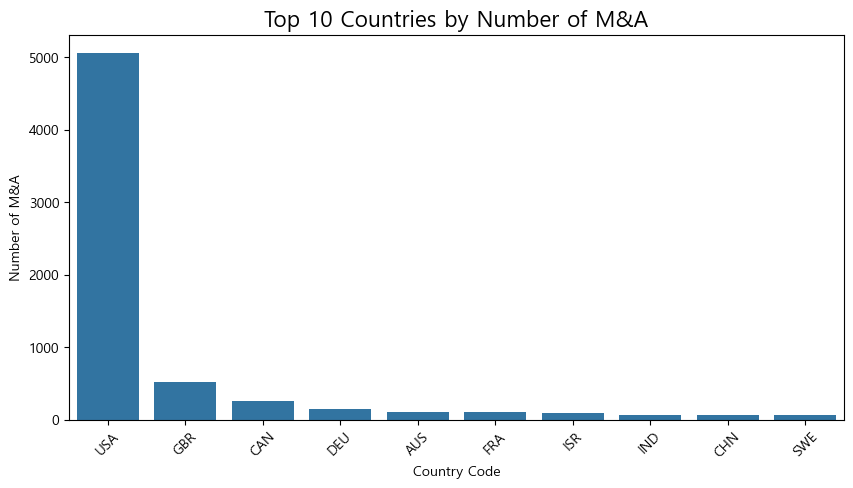

In [32]:
# 나라별 M&A 수
mna_by_country = (
    mna_addr
    .groupby("country_code_x")["acquired_c_id"]
    .nunique()
    .reset_index(name="n_mna")
)

display(mna_by_country.sort_values(by="n_mna", ascending=False))

# 상위 10개 국가 - bar
top10 = mna_by_country.nlargest(10, "n_mna")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top10,
    x="country_code_x",
    y="n_mna"
)

plt.title("Top 10 Countries by Number of M&A", fontsize=16)
plt.xlabel("Country Code")
plt.ylabel("Number of M&A")
plt.xticks(rotation=45)
plt.show()

,obj_state_filled,n_mna
5,CA,1849
35,NY,432
20,MA,383
45,TX,263
50,WA,197
15,IL,153
47,VA,131
10,FL,127
32,NJ,126
6,CO,125


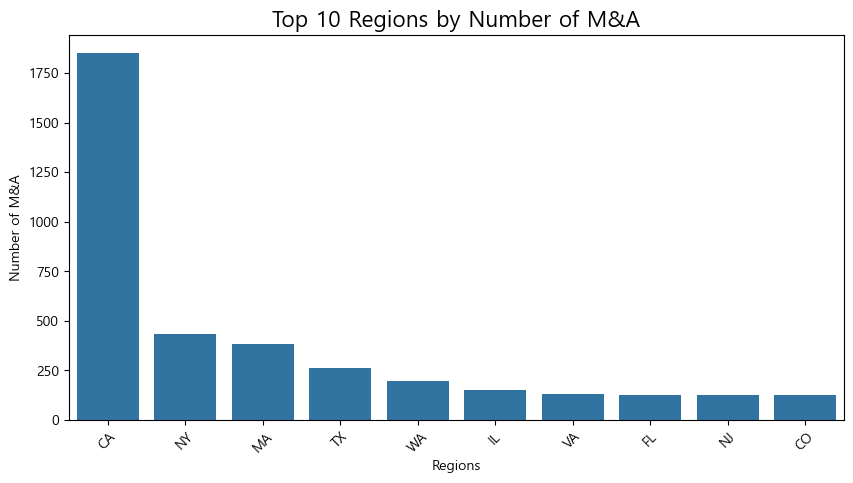

In [33]:
# 지역별 M&A 수
mna_by_region = (
    mna_addr
    .groupby("obj_state_filled")["acquired_c_id"]
    .nunique()
    .reset_index(name="n_mna")
)

display(mna_by_region.sort_values(by="n_mna", ascending=False))

# 상위 10개 지역 - bar
top10 = mna_by_region.nlargest(10, "n_mna")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top10,
    x="obj_state_filled",
    y="n_mna"
)

plt.title("Top 10 Regions by Number of M&A", fontsize=16)
plt.xlabel("Regions")
plt.ylabel("Number of M&A")
plt.xticks(rotation=45)
plt.show()

#### 성장률(이슈/마일스톤)
(mile, obj, fr)

In [34]:
# 기본구조 확인
print(df_mna_issues.shape) # (39575, 57)
print(df_mna_issues.columns.tolist())

display(df_mna_issues.head())

(39575, 62)
['Unnamed: 0', 'mile_cfpr_id', 'milestone_at', 'description_x', 'cat_mile_description', 'objects_cfpr_id', 'entity_type', 'parent_c_id', 'normalized_name', 'category_code', 'status', 'founded_at', 'closed_at', 'description_y', 'overview', 'tag_list', 'country_code', 'state_code', 'city', 'region', 'first_investment_at', 'last_investment_at', 'investment_rounds', 'invested_companies', 'first_funding_at', 'last_funding_at', 'funding_rounds', 'funding_total_usd', 'first_milestone_at', 'last_milestone_at', 'milestones', 'relationships', 'is_obj_parent_id_missing', 'is_obj_category_missing', 'is_obj_founded_missing', 'is_obj_closed_missing', 'is_obj_overview_missing', 'is_obj_state_missing', 'is_obj_inv_rounds_missing', 'is_obj_inv_comp_missing', 'cat_obj_status', 'obj_overview_fixed', 'cat_obj_overview', 'obj_region_fixed', 'cat_obj_region', 'obj_state_filled', 'obj_city_fixed', 'obj_category_filled', 'is_obj_funding_total_usd_private', 'is_obj_funding_rounds_private', 'acquisi

,Unnamed: 0,mile_cfpr_id,milestone_at,description_x,cat_mile_description,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description_y,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,...,is_obj_state_missing,is_obj_inv_rounds_missing,is_obj_inv_comp_missing,cat_obj_status,obj_overview_fixed,cat_obj_overview,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private,acquisition_id,acquiring_c_id,acquired_c_id,term_code,price_amount,price_currency_code,acquired_at,is_acq_price_private,is_acquisitions_acq_at_missing,price_amount_usd,acqusition_currency_rate,is_acquired
0,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,0.0,0.0,0.0,ipo,"created in 2006, twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world. we see a billion tweets every 2.5 days on every conceivable topic. world leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active twitter accounts through which users can truly get the pulse of the planet",Software & Technology,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,c:3138,2008-06-17,Twhirl announces support for Seesmic video playback.,product_update,c:3138,Company,NaN,twhirl,software,acquired,2007-11-12,NaN,Twitter Desktop Client,"Twhirl is a free desktop client for the Twitter microblogging service that is powered by the cross-platform Adobe AIR. The application helps the user sort through incoming ""Tweets"" by color coding them and allowing timeline filtering and visual & auditory notifications.\n\nThere are many additional features that are not available on the standard Twitter site, such as favorites settings, URL shortening, customizable color schemes, multiple Twitter account connections, localization, and cross-posting capabilities to Pownce and Jaiku!","AIR, twitter, pownce, jaiku, microblogging",NaN,NaN,NaN,unknown,NaN,NaN,0.0,0.0,NaN,...,1.0,0.0,0.0,acquired,"twhirl is a free desktop client for the twitter microblogging service that is powered by the cross-platform adobe air. the application helps the user sort through incoming ""tweets"" by color coding them and allowing timeline filtering and visual & auditory notifications. there are many additional features that are not available on the standard twitter site, such as favorites settings, url shortening, customizable color schemes, multiple twitter account connections, localization, and cross-posting capabilities to pownce and jaiku!",Software & Technology,NaN,NaN,NaN,NaN,software,1.0,1.0,239.0,c:200,c:3138,NaN,NaN,USD,2008-04-01,1.0,0.0,NaN,1.0,1
2,2,c:59,2008-06-18,"More than 4 Billion videos viewed at Google Sites, 37.9% according to comScore",more,c:59,Company,NaN,google,search,ipo,1998-09-07,NaN,NaN,"Google provides search and advertising services, which together aim to organize and monetize the world's information. In addition to its dominant search engine, it offers a plethora of online tools and platforms including: [Gm

In [35]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
print(df_mna_issues.shape[0]) # 39575
cond = (df_mna_issues["mile_cfpr_id"].str[0] == "c")
mna_issues = df_mna_issues[cond].copy()
print(mna_issues.shape[0]) # 28826

39575
28826


,n_milestones,n_milestone_types,is_acquired
count,12389.0,12389.000000,12389.000000
mean,1.0,1.744854,0.080152
std,0.0,1.618939,0.271539
min,1.0,1.000000,0.000000
25%,1.0,1.000000,0.000000
50%,1.0,1.000000,0.000000
75%,1.0,2.000000,0.000000
max,1.0,36.000000,1.000000


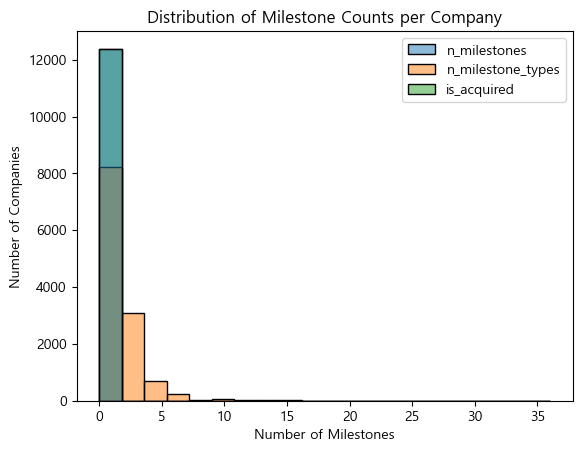

In [36]:
# 회사별 마일스톤 수
mna_mile_counts = (
    mna_issues
    .groupby("mile_cfpr_id")
    .agg(
        n_milestones=("mile_cfpr_id", "nunique"),          # 마일스톤 개수
        n_milestone_types=("cat_mile_description", "nunique"),  # 마일스톤 유형 개수
        is_acquired  = ("is_acquired", "max")        # 회사별 M&A 성공 여부(한 번이라도 1이면 1)
    )
    .reset_index()
)
# display(mna_mile_counts)
display(mna_mile_counts.describe())

sns.histplot(mna_mile_counts, bins=20)
plt.title("Distribution of Milestone Counts per Company")
plt.xlabel("Number of Milestones")
plt.ylabel("Number of Companies")
plt.show()

In [37]:
# M&A 이력있는 회사가 가진 milestone 유형
cond1 = (mna_issues["is_acquired"]==1)
mna_issues.loc[cond1, "cat_mile_description"].value_counts()

cat_mile_description
launch         389
acquisition    360
award          131
funding         95
announce        89
              ... 
kaptur           1
aeg              1
oyster           1
sge              1
perion           1
Name: count, Length: 594, dtype: int64

In [38]:
mna_issues["acquired_at"] = pd.to_datetime(mna_issues["acquired_at"], errors="coerce")
mna_issues["founded_at"] = pd.to_datetime(mna_issues["founded_at"], errors="coerce")
mna_issues["closed_at"] = pd.to_datetime(mna_issues["closed_at"], errors="coerce")


In [39]:
# M&A 이력있는 회사의 M&A 1년이내에 가진 milestone 유형
cond1 = (mna_issues["is_acquired"]==1)
cond2 = (mna_issues["acquired_at"])
mna_issues.loc[cond1, "cat_mile_description"].value_counts()

cat_mile_description
launch         389
acquisition    360
award          131
funding         95
announce        89
              ... 
kaptur           1
aeg              1
oyster           1
sge              1
perion           1
Name: count, Length: 594, dtype: int64

마일스톤의 수 분포와 M&A 여부

In [40]:
# M&A 성공 스타트업의 평균 마일스톤 횟수 계산
# M&A 성공한 스타트업만 필터
mna_acq_companies = mna_mile_counts[mna_mile_counts["is_acquired"] == 1]

# 평균 마일스톤 횟수 계산
mna_acq_avg_mile = mna_acq_companies["n_milestones"].mean()

print("M&A 성공한 스타트업의 평균 마일스톤 횟수:", mna_acq_avg_mile)


M&A 성공한 스타트업의 평균 마일스톤 횟수: 1.0


M&A 성공 vs 비성공 평균 마일스톤 비교

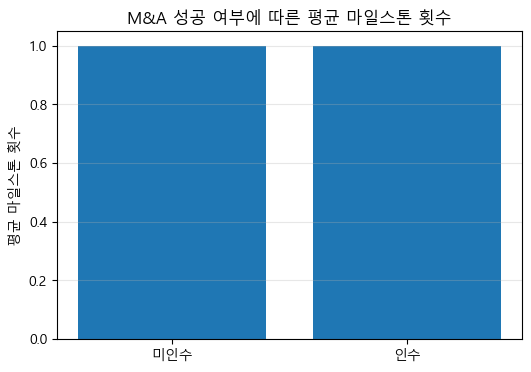

In [41]:
# M&A 성공 vs 비성공 평균 마일스톤 비교

# 1) M&A 성공 여부별 평균 마일스톤 횟수 집계
mna_acq_mean_by_group = (
    mna_mile_counts
      .groupby("is_acquired")["n_milestones"]
      .mean()
      .reset_index()
)

# is_acquired를 0/1 → 라벨로 바꾸면 보기 더 편함
mna_acq_mean_by_group["acq_label"] = mna_acq_mean_by_group["is_acquired"].map({0: "미인수", 1: "인수"})

# 2) 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(mna_acq_mean_by_group["acq_label"], mna_acq_mean_by_group["n_milestones"])
plt.ylabel("평균 마일스톤 횟수")
plt.title("M&A 성공 여부에 따른 평균 마일스톤 횟수")
plt.grid(axis="y", alpha=0.3)
plt.show()


M&A 성공 스타트업 내부 분포

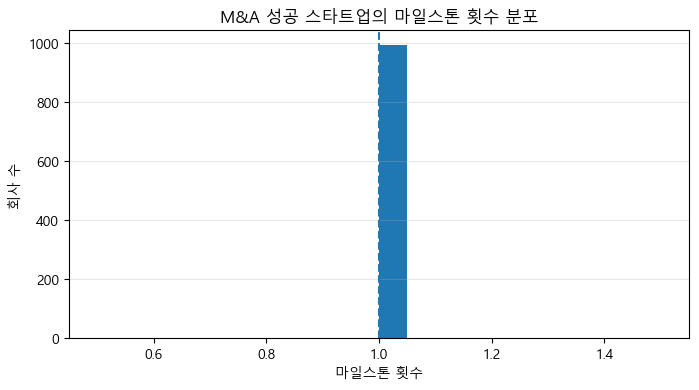

In [42]:
# M&A 성공 스타트업 내부 분포 보기
# M&A 성공 스타트업들의 마일스톤 횟수 분포
mna_mile_acq = mna_acq_companies["n_milestones"]

plt.figure(figsize=(8, 4))
plt.hist(mna_mile_acq, bins=20)
plt.axvline(mna_mile_acq.mean(), linestyle="--")
plt.xlabel("마일스톤 횟수")
plt.ylabel("회사 수")
plt.title("M&A 성공 스타트업의 마일스톤 횟수 분포")
plt.grid(axis="y", alpha=0.3)
plt.show()


마일스톤 유형 수 분포와 M&A 여부

In [43]:
# 1) 회사별 마일스톤 유형 수 & M&A 여부 요약
mna_acq_mile_types = (
    df_mna_issues
      .groupby("objects_cfpr_id")
      .agg(
          n_milestone_types = ("cat_mile_description", "nunique"),  # 서로 다른 마일스톤 유형 개수
          is_acquired       = ("is_acquired", "max")                # 회사 단위 M&A 여부 (한 번이라도 1이면 1)
      )
      .reset_index()
)

mna_acq_mile_types.head()

,objects_cfpr_id,n_milestone_types,is_acquired
0,c:1,2,0
1,c:100,1,1
2,c:10009,1,0
3,c:1001,1,1
4,c:10014,1,1


In [44]:
# 전체 마일스톤 유형 수 분포
mna_acq_mile_types["n_milestone_types"].describe()

count    17009.000000
mean         1.700100
std          1.777472
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         42.000000
Name: n_milestone_types, dtype: float64

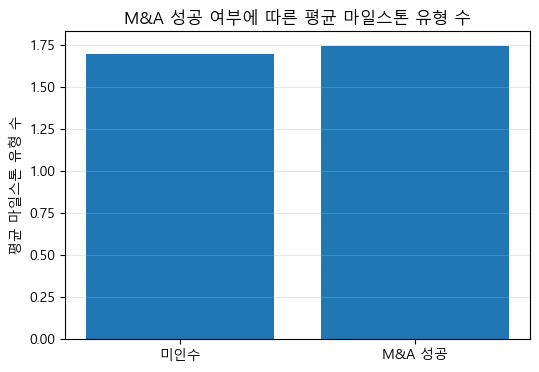

In [45]:
# M&A 여부별 “평균 마일스톤 유형 수”
# 3-1) M&A 여부별 평균 마일스톤 유형 수
mean_types_by_acq = (
    mna_acq_mile_types
      .groupby("is_acquired")["n_milestone_types"]
      .mean()
      .reset_index()
)

# 0/1 → 라벨로 바꾸기
mean_types_by_acq["acq_label"] = mean_types_by_acq["is_acquired"].map(
    {0: "미인수", 1: "M&A 성공"}
)

# 3-2) 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(mean_types_by_acq["acq_label"], mean_types_by_acq["n_milestone_types"])
plt.ylabel("평균 마일스톤 유형 수")
plt.title("M&A 성공 여부에 따른 평균 마일스톤 유형 수")
plt.grid(axis="y", alpha=0.3)
plt.show()


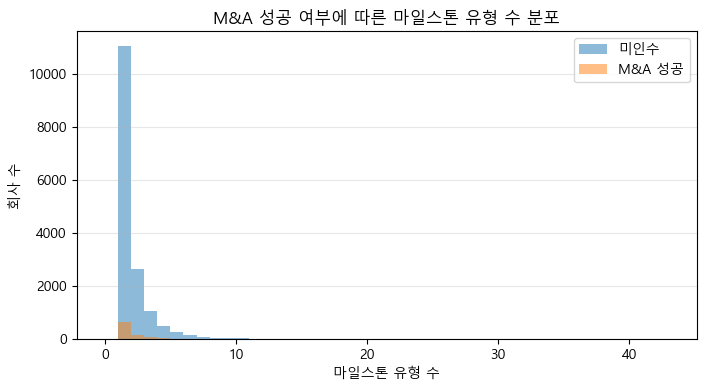

In [46]:
# M&A 성공/미성공 그룹별 분포 비교
# 4-1) 성공/미성공 그룹 분리
types_acquired   = mna_acq_mile_types[mna_acq_mile_types["is_acquired"] == 1]["n_milestone_types"]
types_not_acq    = mna_acq_mile_types[mna_acq_mile_types["is_acquired"] == 0]["n_milestone_types"]

# 4-2) 히스토그램 (두 그룹 비교)
plt.figure(figsize=(8, 4))

plt.hist(types_not_acq, bins=range(0, types_not_acq.max() + 2), alpha=0.5, label="미인수")
plt.hist(types_acquired, bins=range(0, types_acquired.max() + 2), alpha=0.5, label="M&A 성공")

plt.xlabel("마일스톤 유형 수")
plt.ylabel("회사 수")
plt.title("M&A 성공 여부에 따른 마일스톤 유형 수 분포")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


M&A 성공한 회사가 가지고있는 milestone의 category 유형

In [47]:
# 1) M&A 성공한 마일스톤 행만 필터
mna_acq_company = mna_issues[mna_issues["is_acquired"] == 1].copy()

mna_acq_company[["objects_cfpr_id", "cat_mile_description"]].head()


,objects_cfpr_id,cat_mile_description
1,c:3138,product_update
3,c:314,launch
4,c:314,product_update
11,c:1388,acquisition
12,c:75,leadership_change


In [48]:
# 2) 회사-카테고리 단위로 중복 제거
mna_acq_company_cat = (
    mna_acq_company[["objects_cfpr_id", "cat_mile_description"]]
      .dropna(subset=["cat_mile_description"])
      .drop_duplicates()
)

mna_acq_company_cat.head()

,objects_cfpr_id,cat_mile_description
1,c:3138,product_update
3,c:314,launch
4,c:314,product_update
11,c:1388,acquisition
12,c:75,leadership_change


In [49]:
# 3) 카테고리별로, 그 카테고리를 가진 M&A 성공 회사 수 집계
mna_acq_cat_stats = (
    mna_acq_company_cat
      .groupby("cat_mile_description")
      .agg(
          n_companies=("objects_cfpr_id", "nunique")  # 이 카테고리를 가진 M&A 성공 회사 수
      )
      .reset_index()
      .sort_values("n_companies", ascending=False)
)

mna_acq_cat_stats.head(20)

,cat_mile_description,n_companies
18,acquisition,298
276,launch,210
48,award,83
188,funding,82
222,hiring,75
33,announce,66
372,partnership,44
399,product_update,34
82,buy,31
371,partner,25


In [50]:
# 전체 M&A 성공 회사 수
n_acq_companies = df_mna_issues.loc[df_mna_issues["is_acquired"] == 1, "objects_cfpr_id"].nunique()

mna_acq_cat_stats["company_ratio_%"] = mna_acq_cat_stats["n_companies"] / n_acq_companies * 100

mna_acq_cat_stats.head(20)


,cat_mile_description,n_companies,company_ratio_%
18,acquisition,298,30.070636
276,launch,210,21.190716
48,award,83,8.375378
188,funding,82,8.274470
222,hiring,75,7.568113
33,announce,66,6.659939
372,partnership,44,4.439960
399,product_update,34,3.430878
82,buy,31,3.128153
371,partner,25,2.522704


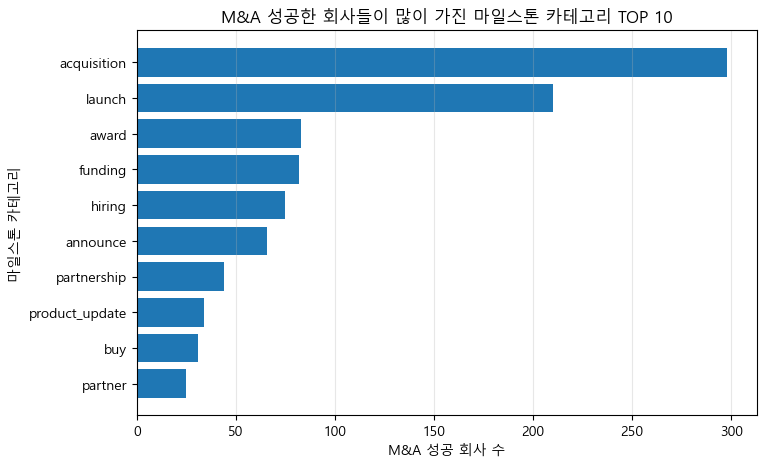

In [51]:
# TOP 10 카테고리만 사용
topN = 10
plot_data = mna_acq_cat_stats.head(topN)

plt.figure(figsize=(8, 5))
plt.barh(plot_data["cat_mile_description"], plot_data["n_companies"])
plt.xlabel("M&A 성공 회사 수")
plt.ylabel("마일스톤 카테고리")
plt.title("M&A 성공한 회사들이 많이 가진 마일스톤 카테고리 TOP 10")
plt.gca().invert_yaxis()  # 위에서부터 큰 값이 보이게
plt.grid(axis="x", alpha=0.3)
plt.show()

M&A 성공 회사 vs 미성공 회사

In [52]:
# 1) M&A 여부, 회사, 카테고리만 사용
mna_mile_cat = df_mna_issues[["objects_cfpr_id", "cat_mile_description", "is_acquired"]].copy()

# 2) 카테고리 결측 제거
mna_mile_cat = mna_mile_cat.dropna(subset=["cat_mile_description"])

# 3) 회사-카테고리 단위로 중복 제거
mna_company_cat = mna_mile_cat.drop_duplicates(["objects_cfpr_id", "cat_mile_description"])

mna_company_cat.head()

,objects_cfpr_id,cat_mile_description,is_acquired
0,c:12,survives,0
1,c:3138,product_update,1
2,c:59,more,0
3,c:314,launch,1
4,c:314,product_update,1


In [53]:
# 2-1) M&A 성공 그룹만
mna_acq_cat = mna_company_cat[mna_company_cat["is_acquired"] == 1].copy()

# 카테고리별: 이 카테고리를 가진 '성공 회사 수'
mna_acq_cat_stats = (
    mna_acq_cat
      .groupby("cat_mile_description")
      .agg(
          n_companies_acq=("objects_cfpr_id", "nunique")
      )
      .reset_index()
)

# 전체 M&A 성공 회사 수 (분모)
mna_total_acq_companies = mna_company_cat.loc[mna_company_cat["is_acquired"] == 1, "objects_cfpr_id"].nunique()

# 성공 그룹 내 비율(%)
mna_acq_cat_stats["acq_ratio_%"] = mna_acq_cat_stats["n_companies_acq"] / mna_total_acq_companies * 100

mna_acq_cat_stats.head()


,cat_mile_description,n_companies_acq,acq_ratio_%
0,'return,1,0.100908
1,1,1,0.100908
2,10,1,0.100908
3,100,2,0.201816
4,2,2,0.201816


In [54]:
# 2-2) M&A 미성공 그룹
mna_non_acq_cat = mna_company_cat[mna_company_cat["is_acquired"] == 0].copy()

mna_non_acq_cat_stats = (
    mna_non_acq_cat
      .groupby("cat_mile_description")
      .agg(
          n_companies_nonacq=("objects_cfpr_id", "nunique")
      )
      .reset_index()
)

mna_total_nonacq_companies = mna_company_cat.loc[mna_company_cat["is_acquired"] == 0, "objects_cfpr_id"].nunique()

mna_non_acq_cat_stats["nonacq_ratio_%"] = mna_non_acq_cat_stats["n_companies_nonacq"] / mna_total_nonacq_companies * 100

mna_non_acq_cat_stats.head()


,cat_mile_description,n_companies_nonacq,nonacq_ratio_%
0,'return,1,0.006243
1,'tis,1,0.006243
2,0,1,0.006243
3,1,48,0.299663
4,10,16,0.099888


In [55]:
# 3) 성공/미성공 카테고리 통계 병합
mna_mile_cat_compare = (
    mna_acq_cat_stats
      .merge(mna_non_acq_cat_stats, on="cat_mile_description", how="outer")
      .fillna(0)   # 일부 category가 한쪽 그룹에만 있을 수 있으므로 0으로 채움
)

# lift(성공 그룹 비율 / 미성공 그룹 비율) 계산 (0 division 방어)
mna_mile_cat_compare["lift_acq_over_nonacq"] = mna_mile_cat_compare.apply(
    lambda row: row["acq_ratio_%"] / row["nonacq_ratio_%"] if row["nonacq_ratio_%"] > 0 else None,
    axis=1
)

# 성공 그룹 비율이 높은 순으로 정렬
mna_mile_cat_compare = mna_mile_cat_compare.sort_values("acq_ratio_%", ascending=False)

mna_mile_cat_compare.head(20)


,cat_mile_description,n_companies_acq,acq_ratio_%,n_companies_nonacq,nonacq_ratio_%,lift_acq_over_nonacq
216,acquisition,298.0,30.070636,1676.0,10.463229,2.873935
3252,launch,210.0,21.190716,3696.0,23.074042,0.918379
683,award,83.0,8.375378,1490.0,9.302035,0.900381
2294,funding,82.0,8.274470,2108.0,13.160195,0.628750
2625,hiring,75.0,7.568113,1514.0,9.451867,0.800700
474,announce,66.0,6.659939,877.0,5.475091,1.216407
4235,partnership,44.0,4.439960,539.0,3.364964,1.319467
4500,product_update,34.0,3.430878,580.0,3.620926,0.947514
1002,buy,31.0,3.128153,210.0,1.311025,2.386036
4233,partner,25.0,2.522704,433.0,2.703209,0.933226


In [56]:
topN = 10

# 성공 비율 기준 상위 N개 카테고리만
mna_plot_data = mna_mile_cat_compare.head(topN)

mna_plot_data[["cat_mile_description", "acq_ratio_%", "nonacq_ratio_%", "lift_acq_over_nonacq"]]


,cat_mile_description,acq_ratio_%,nonacq_ratio_%,lift_acq_over_nonacq
216,acquisition,30.070636,10.463229,2.873935
3252,launch,21.190716,23.074042,0.918379
683,award,8.375378,9.302035,0.900381
2294,funding,8.274470,13.160195,0.628750
2625,hiring,7.568113,9.451867,0.800700
474,announce,6.659939,5.475091,1.216407
4235,partnership,4.439960,3.364964,1.319467
4500,product_update,3.430878,3.620926,0.947514
1002,buy,3.128153,1.311025,2.386036
4233,partner,2.522704,2.703209,0.933226


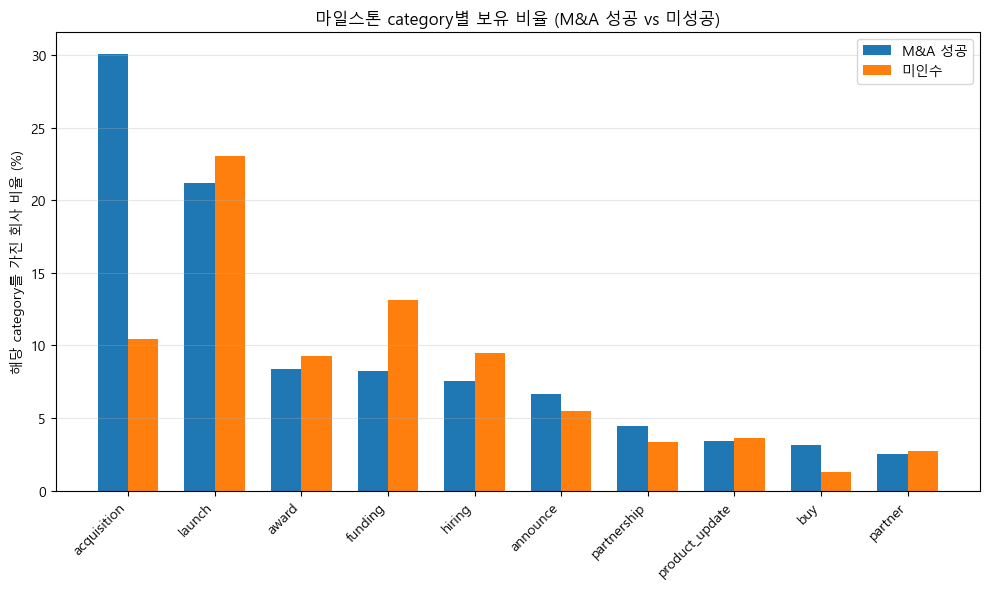

In [57]:
plt.figure(figsize=(10, 6))

x = np.arange(len(mna_plot_data))
width = 0.35

plt.bar(x - width/2, mna_plot_data["acq_ratio_%"],   width, label="M&A 성공")
plt.bar(x + width/2, mna_plot_data["nonacq_ratio_%"], width, label="미인수")

plt.xticks(x, mna_plot_data["cat_mile_description"], rotation=45, ha="right")
plt.ylabel("해당 category를 가진 회사 비율 (%)")
plt.title("마일스톤 category별 보유 비율 (M&A 성공 vs 미성공)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
